In [6]:
import librosa
import numpy as np
import matplotlib.pyplot as plt


In [7]:
def wav2feat(wavfile):
    '''                       
    Input: audio wav file name
    Output: Magnitude spectrogram
    '''                                                
    x, Fs = librosa.load(wavfile, sr=44100, mono=True) 

    hop = int(0.01 * Fs) # 10ms
    win = int(0.02 * Fs) # 20ms
    X = librosa.stft(x, n_fft=1024, hop_length=hop, win_length=win, window='hann', center=True, pad_mode='reflect')
    return np.abs(X)
    

In [ ]:
!pip install noisereduce
import noisereduce as nr

x,Fx = librosa.load('/content/102104-3-0-0.wav', sr=44100, mono=True)
noisy_part = x[0:25000]
reduced_noise = nr.reduce_noise(audio_clip=x, noise_clip=noisy_part, verbose=False)
print("Original audio file:")
plt.plot(x)
print("Noise removed audio file:")
plt.plot(reduced_noise)
librosa.output.write_wav('/content/101.wav', reduced_noise, sr = 44100, norm=False)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import matplotlib.pyplot as plot
from scipy.io import wavfile

samplingFrequency, signalData = wavfile.read("/content/drive/MyDrive/audio_train_1ch/105415-2-0-15.wav")
feature = wav2feat("/content/drive/MyDrive/audio_train_1ch/105415-2-0-15.wav")
print(feature.shape)


(513, 401)


IndexError: ignored

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
y = pd.read_csv("/content/drive/MyDrive/labels_train.csv")
# creating initial dataframe
sound_types = y['class'].to_list()
sound_df = pd.DataFrame(sound_types, columns=['Sound_Types'])
# creating instance of labelencoder
labelencoder = LabelEncoder()
# Assigning numerical values and storing in another column
sound_df['Sound_Types_Cat'] = labelencoder.fit_transform(sound_df['Sound_Types'])
sound_df

,Sound_Types,Sound_Types_Cat
0,dog_bark,3
1,dog_bark,3
2,dog_bark,3
3,dog_bark,3
4,dog_bark,3
...,...,...
1756,street_music,9
1757,street_music,9
1758,street_music,9
1759,street_music,9


In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoding = OneHotEncoder()
y = encoding.fit_transform(sound_df[['Sound_Types_Cat']]).toarray()

In [ ]:
def padding(X):
  if X.shape[1]!=401:
    pad = np.zeros((X.shape[0],401-X.shape[1]))
    X = np.hstack((X,pad))
  return X

In [ ]:
X_train = []
N = sound_df['Sound_Types'].size
for i in range(N):
  file_ = y['slice_file_name'][i]
  if i%100==0:
    print('Done '+str(i*100/N))
  X_train.append(padding(wav2feat('/content/drive/MyDrive/audio_train_1ch/'+file_)))
X_train = np.array(X_train)

Done 0.0
Done 5.6785917092561045
Done 11.357183418512209
Done 17.035775127768314
Done 22.714366837024418
Done 28.39295854628052
Done 34.07155025553663
Done 39.75014196479273
Done 45.428733674048836
Done 51.10732538330494
Done 56.78591709256104
Done 62.464508801817146
Done 68.14310051107326
Done 73.82169222032935
Done 79.50028392958546
Done 85.17887563884156
Done 90.85746734809767
Done 96.53605905735378


In [ ]:
np.save('/content/drive/MyDrive/Extracted/X.npy',X_train)
np.save('/content/drive/MyDrive/Extracted/y.npy',y)

In [ ]:
X_train = np.load('/content/drive/MyDrive/Extracted/X.npy')
y = np.load('/content/drive/MyDrive/Extracted/y.npy')

In [ ]:
from sklearn.model_selection import train_test_split
X_train_, X_test, y_train, y_test = train_test_split(X_train, y, test_size=0.2, random_state=42)

In [ ]:
from keras.layers import Conv2D, Input, Dense, MaxPool2D,BatchNormalization,Flatten,Activation,Dropout,GlobalMaxPool2D
from keras.models import Model
def classifierModel(input_shape):
  X_input = Input(input_shape)
  #conv layers
  X = Conv2D(8,5,padding='same')(X_input)
  X = BatchNormalization()(X) 
  X = Activation('relu')(X)
  X = MaxPool2D((2,2))(X)

  X = Conv2D(16,3,padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)
  X = MaxPool2D((2,2))(X)
  X = Dropout(0.5)(X)
  
  X = Flatten()(X)

  X = Dense(64,activation = 'relu')(X)
  X = Dense(32,activation = 'relu')(X)
  
  
  #Softmax Layer
  out = Dense(10,activation='softmax')(X)
  model = Model(inputs=X_input,outputs=out,name='Model')
  return model
model = classifierModel((513,401,1))
model.compile(optimizer='adam',
              loss='categorical_crossentropy', # Loss
              metrics=['accuracy'])

In [ ]:
X_train_ = X_train_.reshape((X_train_.shape[0],513,401,1))
X_test = X_test.reshape(X_test.shape[0],513,401,1)
history = model.fit(X_train_,y_train,epochs=16,batch_size=64,validation_data=(X_test,y_test),shuffle=True)
model.save('model.h5')

In [ ]:
model.summary()

In [ ]:
from sklearn import  svm
X_train_svm = np.mean(X_train_,axis = 2)
X_train_svm = X_train_svm.reshape((X_train_.shape[0],513))
y_hat = np.argmax(y_train,axis=1)
clf = svm.LinearSVC(C=10,dual = False,max_iter = 30000)
clf.fit(X_train_svm,y_hat)


In [ ]:
X_test_svm = np.mean(X_test,axis = 2)
X_test_svm = X_test_svm.reshape((X_test.shape[0],513))
y_true = np.argmax(y_test,axis = -1)
print(clf.score(X_test_svm,y_true))

In [ ]:
ans = np.argmax(model.predict(X_test),axis=-1)
y_test_ = np.argmax(y_test,axis=1)

In [ ]:
res=0
for i in range(len(y_test)):
  if y_test_[i]==ans[i]:
    res+=1
print(res/len(ans))

0.7648725212464589


In [ ]:
for key in history.history.keys():
  print(key)


loss
accuracy
val_loss
val_accuracy


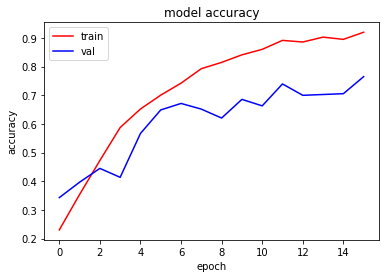

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'b')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_depth = 20)
forest.fit(X_train_svm,np.argmax(y_train,axis = -1))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
forest.score(X_test_svm,y_true)

0.9235127478753541

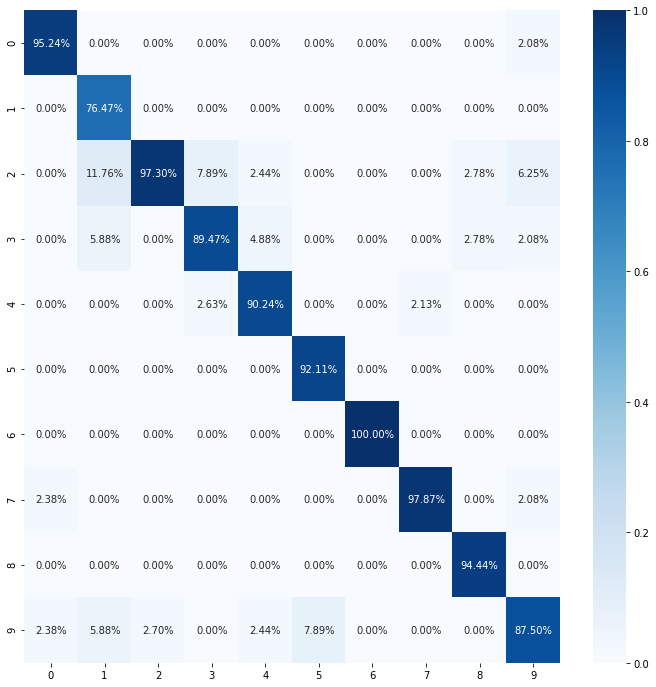

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12,12))
cf_matrix = confusion_matrix(forest.predict(X_test_svm),y_true)
sns.heatmap(cf_matrix/np.sum(cf_matrix,axis =0),cmap = 'Blues',annot = True,fmt = '.2%')

In [ ]:
import pickle

pickle.dump(forest,open('Forest_classifier.sav','wb'))

In [ ]:
loaded_model = pickle.load(open('Forest_classifier.sav', 'rb'))
result = loaded_model.score(X_test_svm, y_true)